### Transfert learning modèles 

In [9]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [17]:
local_weight_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3( input_shape =(150,150,3),
                                include_top=False, 
                               weights = None)

pre_trained_model.load_weights(local_weight_file )

for layer in pre_trained_model.layers:
    layer.trainable = False

In [18]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 74, 74, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 74, 74, 32)   96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 74, 74, 32)   0           batch_normalization_376[0][0]    
_______________________________________________________________________________________

conv2d_425 (Conv2D)             (None, 7, 7, 192)    147456      average_pooling2d_40[0][0]       
__________________________________________________________________________________________________
batch_normalization_416 (BatchN (None, 7, 7, 192)    576         conv2d_416[0][0]                 
__________________________________________________________________________________________________
batch_normalization_419 (BatchN (None, 7, 7, 192)    576         conv2d_419[0][0]                 
__________________________________________________________________________________________________
batch_normalization_424 (BatchN (None, 7, 7, 192)    576         conv2d_424[0][0]                 
__________________________________________________________________________________________________
batch_normalization_425 (BatchN (None, 7, 7, 192)    576         conv2d_425[0][0]                 
__________________________________________________________________________________________________
activation

Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
__________________________________________________________________________________________________


In [25]:
last_layer = pre_trained_model.get_layer('mixed9')
print(last_layer.output_shape)
last_output = last_layer.output

(None, 3, 3, 2048)


In [26]:
from tensorflow.keras.optimizers import RMSprop

In [32]:
# Flatten the output layer to 1 dimension

x = layers.Flatten()(last_output)

# add fully connected layers with 1,024 hidden units and ReLU activation

x = layers.Dense(1024, activation = 'relu')(x)
# # Add a dropout rate of 0.2

x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer for classification

x = layers.Dense(1, activation = "sigmoid")(x)

model = Model (pre_trained_model.input, x)



In [34]:
#####

model.compile(optimizer = RMSprop(lr = 0.0001), 
             loss = 'binary_crossentropy', 
             metrics= ['accuracy'])

In [38]:
# Add our data-augmentation parameters to ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255, 
                                  rotation_range =40, 
                                  width_shift_range = 0.2,
                                  height_shift_range =0.2, 
                                  shear_range =0.2, 
                                  zoom_range = 0.2, 
                                  horizontal_flip = True)

# Note that the validation data should not be augmented!

test_datagen = ImageDataGenerator(rescale = 1/255)



In [43]:
base_dir = 'cats_and_dogs_filtered'
train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

In [47]:
# Flow training images in batches of 20 using train_datagen generator

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                   batch_size = 20,
                                                   class_mode = 'binary', 
                                                   target_size = (150,150))


test_generator = test_datagen.flow_from_directory(validation_dir, 
                                                 batch_size = 20, 
                                                 class_mode = 'binary',
                                                  target_size = (150,150)
                                                
                                                )



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [49]:
history = model.fit_generator(train_generator, 
                            validation_data = test_generator, 
                            steps_per_epoch = 100, 
                            epochs = 20,
                            validation_steps = 50, 
                            verbose = 2)

Epoch 1/20
100/100 - 749s - loss: 0.4333 - accuracy: 0.7860 - val_loss: 0.3435 - val_accuracy: 0.9240
Epoch 2/20
100/100 - 666s - loss: 0.3654 - accuracy: 0.8395 - val_loss: 0.1438 - val_accuracy: 0.9550
Epoch 3/20
100/100 - 690s - loss: 0.3467 - accuracy: 0.8520 - val_loss: 0.2484 - val_accuracy: 0.9450
Epoch 4/20
100/100 - 700s - loss: 0.3032 - accuracy: 0.8620 - val_loss: 0.1970 - val_accuracy: 0.9510
Epoch 5/20
100/100 - 643s - loss: 0.2923 - accuracy: 0.8720 - val_loss: 0.4370 - val_accuracy: 0.9380
Epoch 6/20
100/100 - 628s - loss: 0.2882 - accuracy: 0.8800 - val_loss: 0.2942 - val_accuracy: 0.9460
Epoch 7/20
100/100 - 1232s - loss: 0.3008 - accuracy: 0.8780 - val_loss: 0.4217 - val_accuracy: 0.9410
Epoch 8/20
100/100 - 710s - loss: 0.2818 - accuracy: 0.8840 - val_loss: 0.5411 - val_accuracy: 0.9320
Epoch 9/20
100/100 - 650s - loss: 0.2647 - accuracy: 0.8820 - val_loss: 0.2523 - val_accuracy: 0.9490
Epoch 10/20
100/100 - 680s - loss: 0.2759 - accuracy: 0.8915 - val_loss: 0.3375 -

In [50]:
import matplotlib.pyplot as plt 


In [51]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss =  history.history['val_loss']


<Figure size 432x288 with 0 Axes>

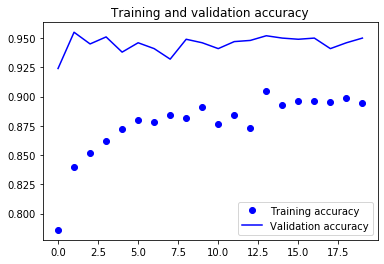

<Figure size 432x288 with 0 Axes>

In [52]:
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()


In [53]:
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()